Using device device


Training Epochs:   0%|          | 0/2048 [00:00<?, ?it/s]

Done!


Training Epochs:   0%|          | 0/2048 [00:00<?, ?it/s]

Done!


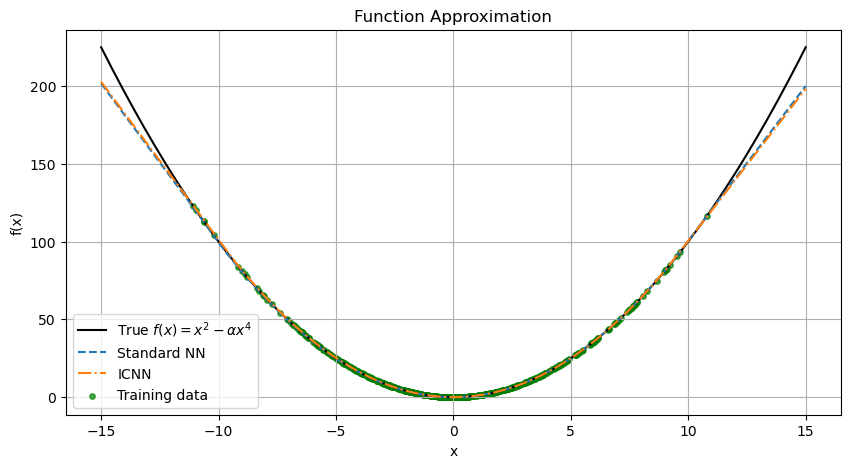

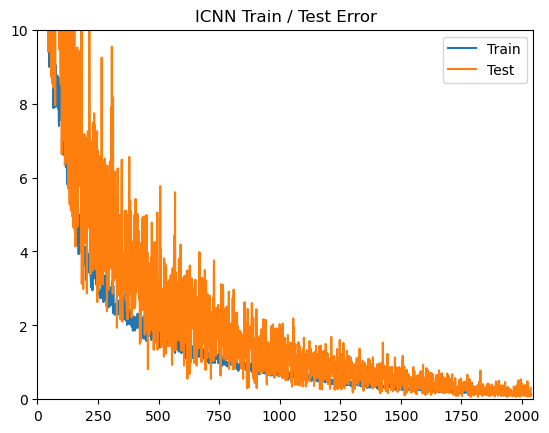

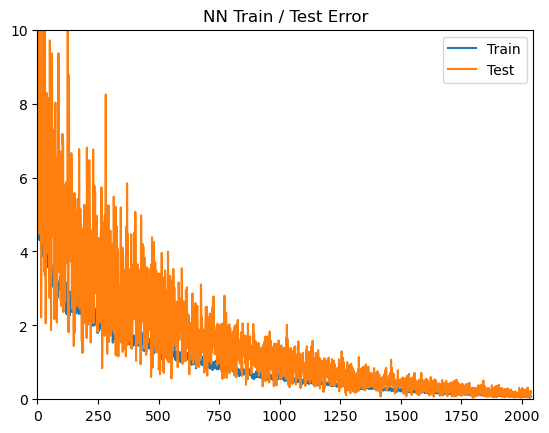

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data as data_utils
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

# -----------------------------
# Standard Feedforward NN Model
# -----------------------------
class FCNN(nn.Module):
    def __init__(self, input_dim):
        super(FCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

# -----------------------------
# Input Convex Neural Network
# -----------------------------
class ICNN(nn.Module):
    def __init__(self, input_dim):
        super(ICNN, self).__init__()
        self.flatten = nn.Flatten()

        # First hidden layer
        self.first_hidden_layer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU()
        )

        # ICNN hidden layers with non-negative W_z
        self.second_layer_linear_prim = nn.Linear(512, 512)
        self.second_layer_linear_skip = nn.Linear(input_dim, 512)
        self.second_layer_act = nn.ReLU()

        self.third_layer_linear_prim = nn.Linear(512, 256)
        self.third_layer_linear_skip = nn.Linear(input_dim, 256)
        self.third_layer_act = nn.ReLU()

        self.fourth_layer_linear_prim = nn.Linear(256, 64)
        self.fourth_layer_linear_skip = nn.Linear(input_dim, 64)
        self.fourth_layer_act = nn.ReLU()

        self.fifth_layer_linear_prim = nn.Linear(64, 16)
        self.fifth_layer_linear_skip = nn.Linear(input_dim, 16)
        self.fifth_layer_act = nn.ReLU()

        self.output_layer_linear_prim = nn.Linear(16, 1)
        self.output_layer_linear_skip = nn.Linear(input_dim, 1)

        # Non-negative weights
        self.nonneg_layers = [layer for name, layer in self.named_modules() if
                              isinstance(layer, nn.Linear) and "prim" in name]

        # Enforce non-negative weights at initialization
        self.clamp_nonneg_weights()

    def clamp_nonneg_weights(self):
        for name, layer in self.named_modules():
            if isinstance(layer, nn.Linear) and "prim" in name:
                layer.weight.data.clamp_(min=0)

    def forward(self, x):
        x = self.flatten(x)
        z1 = self.first_hidden_layer(x)
        z2 = self.second_layer_act(self.second_layer_linear_prim(z1) + self.second_layer_linear_skip(x))
        z3 = self.third_layer_act(self.third_layer_linear_prim(z2) + self.third_layer_linear_skip(x))
        z4 = self.fourth_layer_act(self.fourth_layer_linear_prim(z3) + self.fourth_layer_linear_skip(x))
        z5 = self.fifth_layer_act(self.fifth_layer_linear_prim(z4) + self.fifth_layer_linear_skip(x))
        out = self.output_layer_linear_prim(z5) + self.output_layer_linear_skip(x)
        return out

# -----------------------------
# Training Functions
# -----------------------------

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def train(model, dataloader, optimizer, loss_fn, scheduler=None, max_norm=None):
    # Prepare model for training
    model.train()
    loss_arr = []
    for X, y in dataloader:
        # Get prediction / loss
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_arr.append(loss.item())
        # Do backpropagation
        optimizer.zero_grad()
        loss.backward()
        # Gradient clip (optional)
        if max_norm:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
        # Update weights
        optimizer.step()
        # Optional clamping (for ICNN)
        if isinstance(model, ICNN):
            model.clamp_nonneg_weights()
    return np.mean(loss_arr)

def test(model, dataloader, loss_fn):
    model.eval()
    loss_arr = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            loss_arr.append(loss.item())
    return np.mean(loss_arr)

def train_loop(model, train_loader, test_loader, loss_fn, optimizer, scheduler=None, epochs=1000, max_norm=None):
    # Loop through epochs of training / testing
    train_history, test_history = [], []
    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        train_loss = train(model, train_loader, optimizer, loss_fn, scheduler=scheduler, max_norm=max_norm)
        train_history.append(train_loss)
        test_loss = test(model, test_loader, loss_fn)
        test_history.append(test_loss)
        # Scheduler step
        if scheduler:
            scheduler.step()
    print("Done!")
    return model, train_history, test_history

def print_trained_models_weights(model):
    for name, parameters in model.named_parameters():
        print(f"{name}: {parameters}")

# -----------------------------
# Create Training Data
# -----------------------------

# Generate training data for f(x) = x^2 - alpha x^4 (non-convex)
np.random.seed(0)
torch.manual_seed(0)

def f(x, alpha=0.):
    return x ** 2 - alpha * x ** 4

n_samples = 512
X_np = 4 * np.random.randn(n_samples).reshape(-1, 1)
y_np = f(X_np)

X_train = torch.tensor(X_np, dtype=torch.float32)
y_train = torch.tensor(y_np, dtype=torch.float32)

X_test = torch.linspace(-10, 10, 200).reshape(-1, 1)
y_test = f(X_test)
    
# -----------------------------
# Train Both Models
# -----------------------------

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {'device'} device")

# Initialize models
nn_model = FCNN(input_dim=1)
#nn_model.apply(init_weights)
icnn_model = ICNN(input_dim=1)
#icnn_model.apply(init_weights)

# Loss function and optimizer
loss_fn = nn.MSELoss()  # Mean square error
optimizer_nn = optim.SGD(nn_model.parameters(), lr=0.01, weight_decay=1e-7)
optimizer_icnn = optim.SGD(icnn_model.parameters(), lr=0.01, weight_decay=1e-7)

# Learning rate scheduler
scheduler_icnn = torch.optim.lr_scheduler.StepLR(optimizer_icnn, step_size=64, gamma=0.9)
scheduler_nn = torch.optim.lr_scheduler.StepLR(optimizer_nn, step_size=64, gamma=0.9)

# Number of epochs and batch sizes
n_epochs = 2048  # Number of epochs to run
batch_size = 16  # Size of each batch

# Get training / testing data loaders
train_data = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = data_utils.TensorDataset(X_test, y_test)
test_loader = data_utils.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Train models
nn_model, nn_train_history, nn_test_history = train_loop(nn_model, train_loader, test_loader, loss_fn, optimizer_nn, scheduler=scheduler_nn, epochs=n_epochs, max_norm=10.0)
icnn_model, icnn_train_history, icnn_test_history = train_loop(icnn_model, train_loader, test_loader, loss_fn, optimizer_icnn, scheduler=scheduler_icnn, epochs=n_epochs, max_norm=10.0)

# -----------------------------
# Plotting
# -----------------------------

x_test = torch.linspace(-15, 15, 200).reshape(-1, 1)
y_true = f(x_test)

with torch.no_grad():
    y_nn_pred = nn_model(x_test)
    y_icnn_pred = icnn_model(x_test)

plt.figure(figsize=(10, 5))
plt.plot(x_test, y_true, label='True $f(x) = x^2 - \\alpha x^4$', color='black')
plt.plot(x_test, y_nn_pred, label='Standard NN', linestyle='--')
plt.plot(x_test, y_icnn_pred, label='ICNN', linestyle='-.')

plt.scatter(X_train, y_train, c='green', s=15, alpha=0.7, label='Training data')
plt.title('Function Approximation')
plt.legend()
plt.grid(True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# Test model
plt.title("ICNN Train / Test Error")
plt.plot(np.sqrt(np.array(icnn_train_history))[10:], label="Train")
plt.plot(np.sqrt(np.array(icnn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, n_epochs, 0, 10])
plt.show()

plt.title("NN Train / Test Error")
plt.plot(np.sqrt(np.array(nn_train_history))[10:], label="Train")
plt.plot(np.sqrt(np.array(nn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, n_epochs, 0, 10])
plt.show()

In [4]:
# -----------------------------
# Training / Testing for IEEE Case Data
# -----------------------------

import pathlib

curr_dir = pathlib.Path(".")
data_dir = curr_dir / "training_data"
num_samples = 1000

### Load IEEE case training data for ICNN

# cases = ["case9", "case14", "case30", "case57", "case118", "case300"]

# Define case name
case_name = "case9"
print("Case: ", case_name)

# Load data
df_data = pd.read_csv(data_dir / f"{case_name}_{num_samples}_samples.csv")

# Get feasible data points only
df_data = df_data.loc[df_data["feas_flag"] == 1]
print("Number of samples: ", len(df_data))

# Organize data
num_buses = int((len(df_data.columns) - 2) / 2)
print("Number of buses: ", num_buses)
assert int(case_name.strip("case")) == num_buses
X_columns = [f"Pd{i+1}" for i in range(num_buses)] + [f"Qd{i+1}" for i in range(num_buses)]
assert set(X_columns).issubset(set(df_data.columns))
assert "Cost" in df_data.columns
df_X = df_data[X_columns]
df_y = df_data["Cost"]

# Get input data/labels
X, y = df_X.values, df_y.values.reshape(-1, 1)

### Train Neural Network(s)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Get training / testing data loaders
train_data = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = data_utils.TensorDataset(X_test, y_test)
test_loader = data_utils.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {'device'} device")

# Initialize models
icnn_model = ICNN(input_dim=2 * num_buses)
nn_model = FCNN(input_dim=2 * num_buses)

# Loss function and optimizer
loss_fn = nn.MSELoss()  # Mean square error
optimizer_icnn = optim.SGD(icnn_model.parameters(), lr=0.01)
optimizer_nn = optim.SGD(nn_model.parameters(), lr=0.01)

scheduler_icnn = torch.optim.lr_scheduler.StepLR(optimizer_icnn, step_size=32, gamma=0.9, weight_decay=1e-7)
scheduler_nn = torch.optim.lr_scheduler.StepLR(optimizer_nn, step_size=32, gamma=0.9, weight_decay=1e-7)

# Number of epochs and batch sizes
n_epochs = 2048  # Number of epochs to run
batch_size = 8  # Size of each batch

# Train model(s)
icnn_model, icnn_train_history, icnn_test_history = train_loop(icnn_model, train_loader, test_loader, loss_fn, optimizer_icnn, epochs=n_epochs, scheduler=scheduler_icnn, max_norm=1.0)
nn_model, nn_train_history, nn_test_history = train_loop(nn_model, train_loader, test_loader, loss_fn, optimizer_nn, epochs=n_epochs, scheduler=scheduler_nn, max_norm=1.0)

Case:  case9
Number of samples:  870
Number of buses:  9
Using device device


Training Epochs:   0%|          | 0/2048 [00:00<?, ?it/s]

Done!


Training Epochs:   0%|          | 0/2048 [00:00<?, ?it/s]

Done!


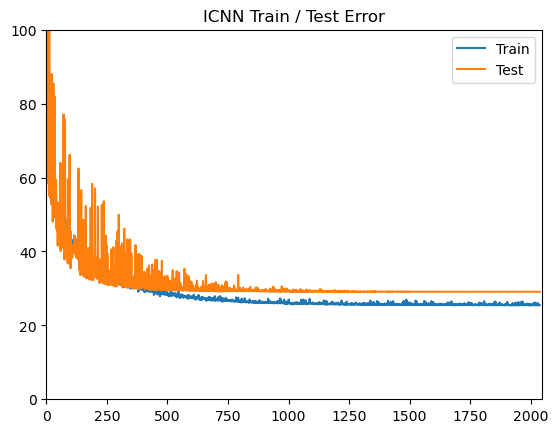

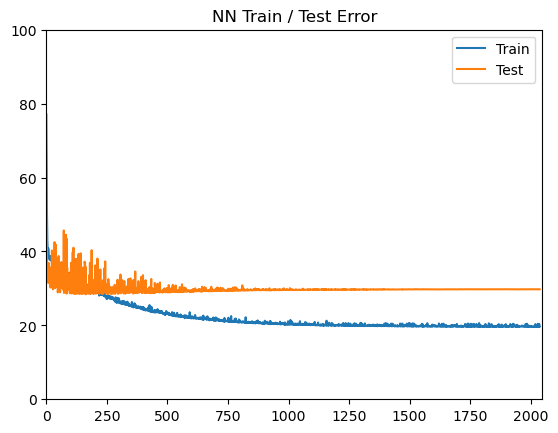

Average cost: $ 2279.02


In [8]:
# Test model
plt.title("ICNN Train / Test Error")
plt.plot(np.sqrt(np.array(icnn_train_history))[10:], label="Train")
plt.plot(np.sqrt(np.array(icnn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, n_epochs, 0, 100])
plt.show()

plt.title("NN Train / Test Error")
plt.plot(np.sqrt(np.array(nn_train_history))[10:], label="Train")
plt.plot(np.sqrt(np.array(nn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, n_epochs, 0, 100])
plt.show()

print(f"Average cost: $ {df_y.mean():.2f}")

In [10]:
(30 / 2279) * 100

1.3163668275559455

### Next thing to try: generating data from... DC OPF?

In [11]:
import numpy as np
import pandapower as pp
import pandapower.networks as pn
from pandapower import rundcopp
from pandapower import OPFNotConverged

In [12]:
case_name = "case9"
net = pn.case9()

In [13]:
load_buses = net.load["bus"]
assert load_buses.is_unique

In [14]:
d = 2 * len(load_buses) # Dimension of load vector subspace

# Think of uniformly sampling a hyper-cube in d-dimensions... N = 50,000 times
N = 5000

# We can just generate points in the hyper-cube, and scale them by their original ranges of values... E.g. [0, max(p_mw)] x [0, max(q_mvar)]
U = np.random.rand(N, d) # Uniform points in the hyper-cube
Pd = U[:, 0:len(load_buses)] * net.load["p_mw"].max()
Qd = U[:, len(load_buses):] * net.load["q_mvar"].max()


In [15]:
columns=[f"P{k}" for k in load_buses] + [f"Q{k}" for k in load_buses] + ["Cost", "Feas"]
columns

['P4', 'P6', 'P8', 'Q4', 'Q6', 'Q8', 'Cost', 'Feas']

In [17]:
Pd_columns = [f"Pd{k}" for k in load_buses]
Qd_columns = [f"Qd{k}" for k in load_buses]
df_results = pd.DataFrame(columns = Pd_columns + Qd_columns + ["Cost", "Feas"])

import time
start = time.time()
for i in range(N):
    net.load["p_mw"] = Pd[i, :]
    net.load["q_mvar"] = Qd[i, :]
    df_results.loc[i, Pd_columns] = net.load["p_mw"].values
    df_results.loc[i, Qd_columns] = net.load["q_mvar"].values
    try:
        rundcopp(net)
        feas = 1
        cost = net.res_cost
    except OPFNotConverged:
        print("Infeasible.")
        feas = 0
        cost = np.inf
    df_results.loc[i, "Cost"] = cost
    df_results.loc[i, "Feas"] = feas
end = time.time()
print(end - start)

Infeasible.
Infeasible.
Infeasible.
Infeasible.
Infeasible.
Infeasible.
Infeasible.
Infeasible.
Infeasible.
Infeasible.
Infeasible.
Infeasible.
36.4845871925354


In [21]:
df_results.to_csv(curr_dir / "training_data" / f"DCOPF_{case_name}_{N}_samples.csv")

In [22]:
# Get feasible data points only
df_data = df_results.loc[df_results["Feas"] == 1]
print("Number of samples: ", len(df_data))

# Organize data
num_buses = int((len(df_data.columns) - 2) / 2)
print("Number of load buses: ", num_buses)
X_columns = Pd_columns + Qd_columns
assert set(X_columns).issubset(set(df_data.columns))
assert "Cost" in df_data.columns
df_X = df_data[X_columns]
df_y = df_data["Cost"]

# Get input data/labels
X, y = df_X.values.astype(np.float64), df_y.values.reshape(-1, 1).astype(np.float64)

### Train Neural Network(s)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Get training / testing data loaders
train_data = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = data_utils.TensorDataset(X_test, y_test)
test_loader = data_utils.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {'device'} device")

# Initialize models
icnn_model = ICNN(input_dim=2 * num_buses)
nn_model = FCNN(input_dim=2 * num_buses)

# Loss function and optimizer
loss_fn = nn.MSELoss()  # Mean square error
optimizer_icnn = optim.SGD(icnn_model.parameters(), lr=0.01, weight_decay=1e-7)
optimizer_nn = optim.SGD(nn_model.parameters(), lr=0.01, weight_decay=1e-7)

scheduler_icnn = torch.optim.lr_scheduler.StepLR(optimizer_icnn, step_size=32, gamma=0.9)
scheduler_nn = torch.optim.lr_scheduler.StepLR(optimizer_nn, step_size=32, gamma=0.9)

# Number of epochs and batch sizes
n_epochs = 2048  # Number of epochs to run
batch_size = 8  # Size of each batch

# Train model(s)
icnn_model, icnn_train_history, icnn_test_history = train_loop(icnn_model, train_loader, test_loader, loss_fn, optimizer_icnn, epochs=n_epochs, scheduler=scheduler_icnn, max_norm=1.0)
nn_model, nn_train_history, nn_test_history = train_loop(nn_model, train_loader, test_loader, loss_fn, optimizer_nn, epochs=n_epochs, scheduler=scheduler_nn, max_norm=1.0)

Number of samples:  4988
Number of load buses:  3
Using device device


Training Epochs:   0%|          | 0/2048 [00:00<?, ?it/s]

Done!


Training Epochs:   0%|          | 0/2048 [00:00<?, ?it/s]

Done!


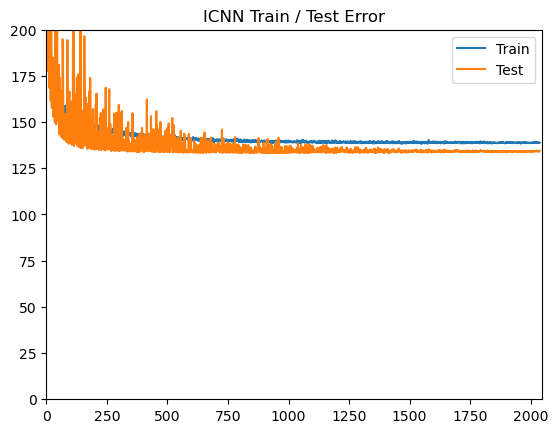

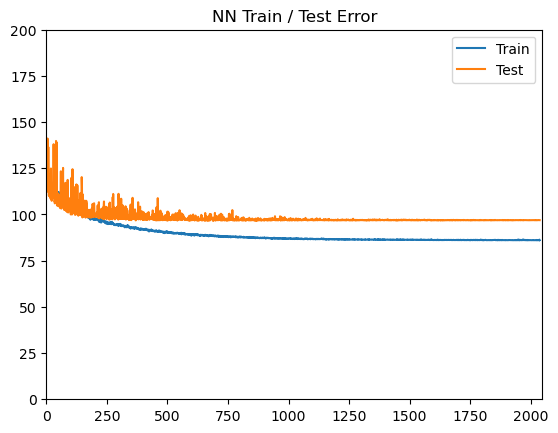

Average cost: $ 2821.26


In [24]:
# Test model
plt.title("ICNN Train / Test Error")
plt.plot(np.sqrt(np.array(icnn_train_history))[10:], label="Train")
plt.plot(np.sqrt(np.array(icnn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, n_epochs, 0, 200])
plt.show()

plt.title("NN Train / Test Error")
plt.plot(np.sqrt(np.array(nn_train_history))[10:], label="Train")
plt.plot(np.sqrt(np.array(nn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, n_epochs, 0, 200])
plt.show()

print(f"Average cost: $ {df_y.mean():.2f}")

In [26]:
np.sqrt(icnn_test_history[-1]) / 2821

np.float64(0.047657417947453075)

In [231]:
# Comparable error. I'd say we're doing pretty well... Should have zero training error...